In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/jovyan/work')

import logging
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import gc
from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.signal import butter, sosfilt
from devito import *
from copy import deepcopy
from distributed import Client, wait, LocalCluster

from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver

from devito_ta.model_geom import get_model, get_geometry, grad_utils
from devito_ta.prepro import Filter, filter_data, CustomSource
from devito_ta.simulation_born import fm_multi_shots, grad_multi_shots, born_multi_shots, normalize
from devito_ta.prepro_dl import train, prepare_data
from devito_ta.plotting import plot_shotrecord_cust, plot_velocity_cust, plot_acquisition_geometry, plot_freq
from deeplearning_ta.attention_r2_unet import *

configuration['log-level'] = 'WARNING'
configuration['opt'] = 'advanced'
logging.getLogger('distributed.nanny').setLevel(logging.ERROR)

In [2]:
file = 'vp_marmousi-ii_10m.segy'

with segyio.open(file, "r", ignore_geometry=True) as ss:
    n_traces = ss.tracecount
    sample_rate = segyio.tools.dt(ss) / 1000
    n_samples =ss.samples.size
    twt = ss.samples
    data = ss.trace.raw[:] 

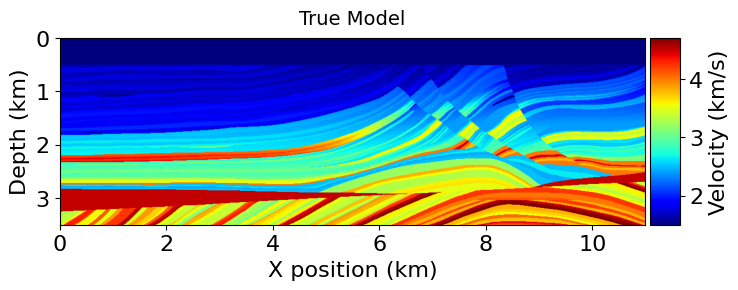

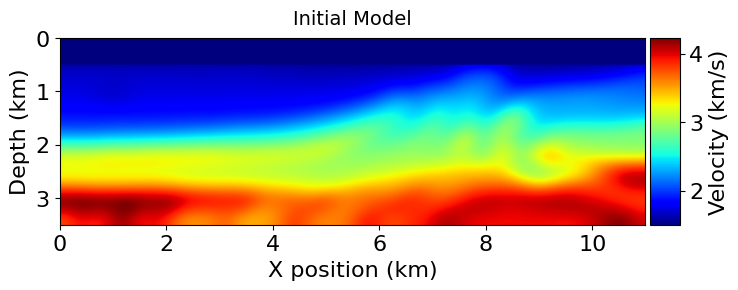

In [3]:
# Define water bottom depth in grid
wb = 50

# Define the model
v = data[200:1300, wb:].copy()             # Remove water layer

# Add water bottom to initial model
water_btm = np.ones((v.shape[0], wb)) * 1.5
v = np.concatenate([water_btm, v], axis=1)

# Create initial model
init = gaussian_filter(v, sigma=[20, 20])  
init[:, :wb] = water_btm

init = np.clip(init, a_min=1.5, a_max=4.5)

# Get model
shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

model1 = get_model(np.clip(v, 1.5, 5), shape, spacing, origin)
model0 = get_model(init, shape, spacing, origin)

# Plot velocity model
plot_velocity_cust(model1, colorbar=True, save=False, title='True Model', name='true_model')
plot_velocity_cust(model0, colorbar=True, save=False, title='Initial Model', name='init_model')


In [4]:
model1.critical_dt

np.float32(1.18)

In [5]:
# Create new geometry for 50 shots
par = {'nx':1100,          'dx':10,       'ox':0,
       'nz':351,          'dz':10,       'oz':0,
       'ns':30,           'ds':300,      'os':2020.0,  'sz':0,
       'nr':200,          'dr':10.0,     'or':0,       'rz':0,
       'nt':4000,         'dt':1.18,        'ot':0,       'nof':20,
       'freq':5,
      }

# Sampling frequency
fs = 1 / (par['dt']/1000)
nbl = model1.nbl

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz'] 

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz'] 

geometry1 = get_geometry(model=model1,
                         src_x=x_s[:, 0],
                         src_z=x_s[:, 1],
                         rec_x=x_r[:, 0],
                         rec_z=x_r[:, 1],
                         t0=0,
                         tn=par['nt'],
                         nof=par['nof'],
                         src_type='Ricker',
                         f0=par['freq']/1000,
                         dt=par['dt'])


n_workers = 6

cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit='auto',
    threads_per_worker=4,
    death_timeout=3600
)

client = Client(cluster)
client.restart()

2025-10-13 19:52:45,637 - distributed.process - WARNING - [<AsyncProcess Dask Worker process (from Nanny)>] process 31601 exit status was already read will report exitcode 255


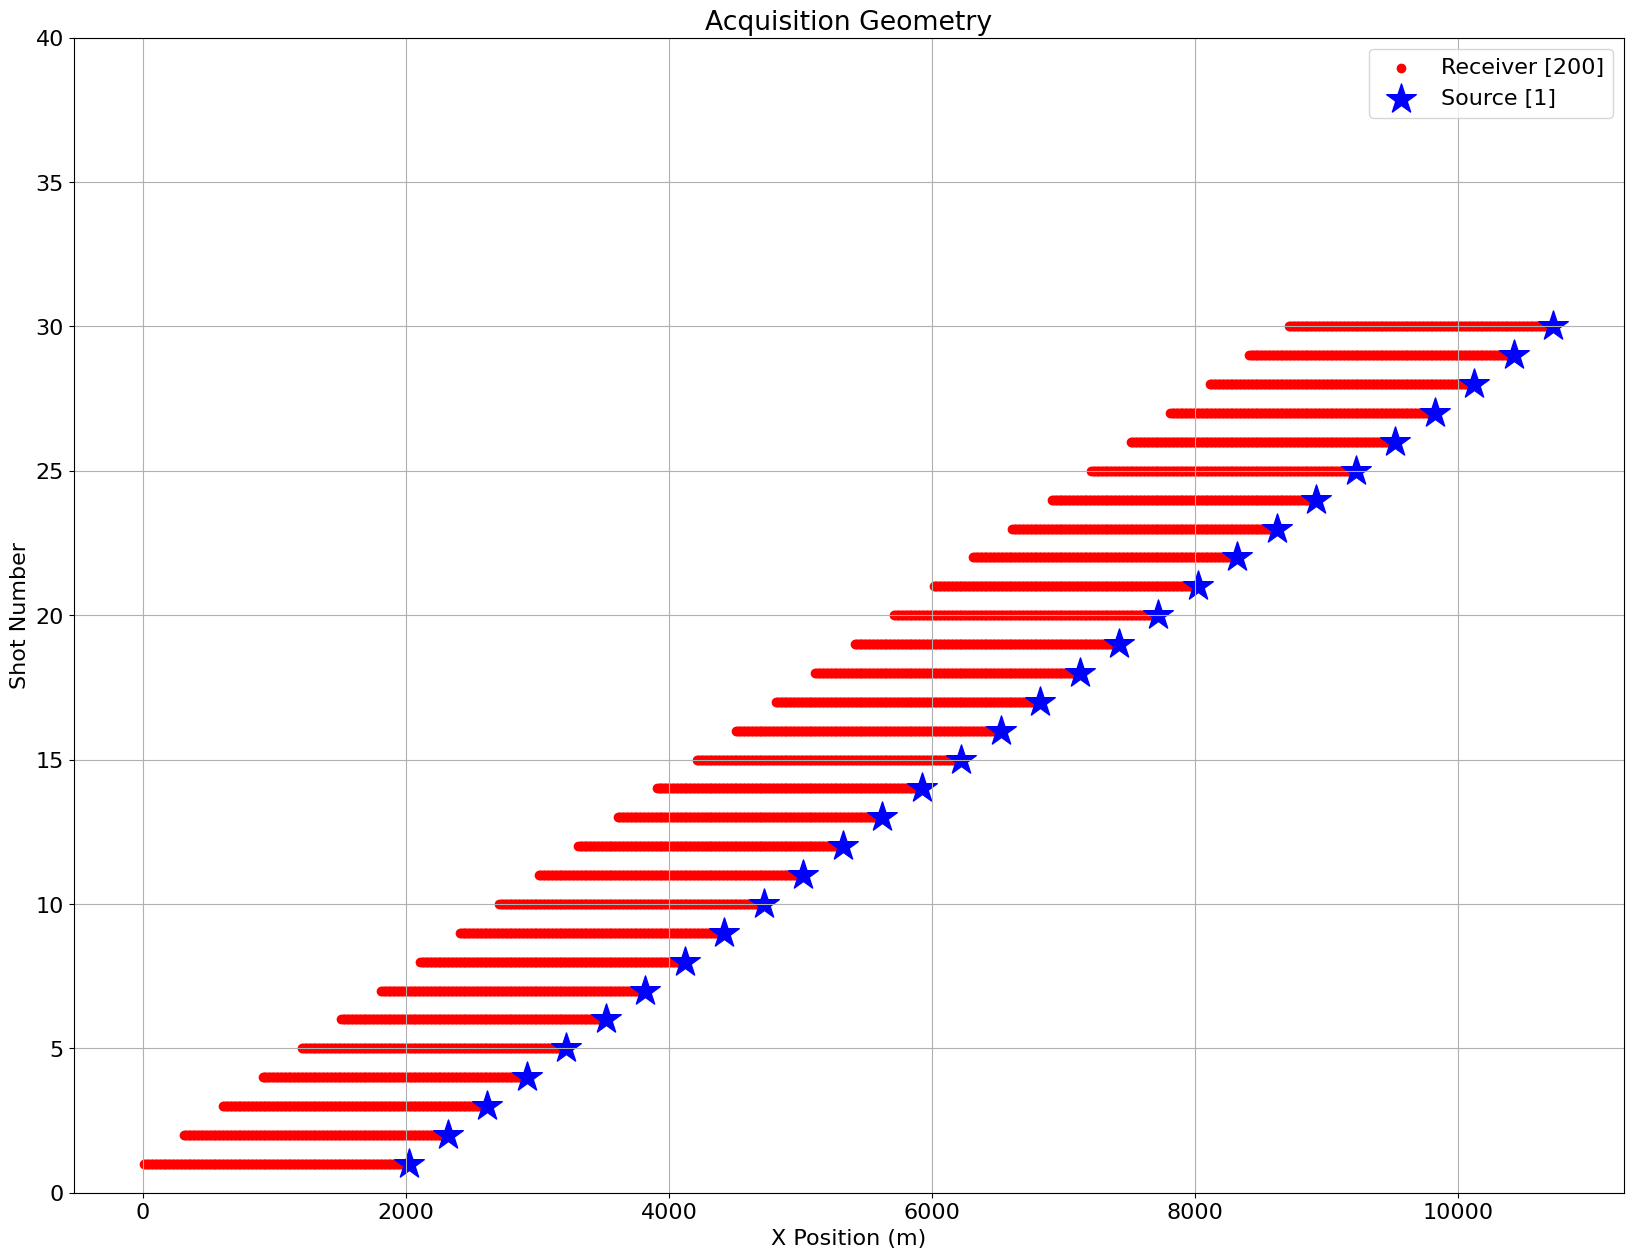

In [6]:
plot_acquisition_geometry(geometry1, 'Acquisition Geometry')

In [7]:
# Perform forward modelling at 10 Hz
dt = par['dt']

start_10hz = time.time()
fm = fm_multi_shots(model1, geometry1, n_workers, client, dt=dt)
finish_10hz = time.time()

duration_10hz = finish_10hz - start_10hz
print(f'Forward modelling duration for 30 shots: {(duration_10hz/60):.2f} minutes')

Operator `Forward` ran in 1.52 s
Operator `Forward` ran in 1.56 s
Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.51 s
Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.48 s
Operator `Forward` ran in 1.55 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.53 s
Operator `Forward` ran in 1.54 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.58 s
Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.57 s
Operator `Forward` ran in 1.52 s
Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.55 s
Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 1.51 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.51 s
Operator `Forward` ran in 1.55 s
Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.49 s


Forward modelling duration for 30 shots: 0.31 minutes


In [8]:
# Make sure dt is match
assert geometry1[0].dt == model1.critical_dt == dt == par['dt']

In [9]:
# Run born fwi

# Create initial guess model for inversion by smoothing the true model
model_up = torch.tensor(model0.vp.data[nbl:-nbl, nbl:-nbl]).T
model_tr = torch.tensor(model1.vp.data[nbl:-nbl, nbl:-nbl]).T
scat = torch.zeros_like(model_up)

# Store to GPU
device = 'cuda'
model_up = model_up.clone().to(device)
model_tr = model_tr.clone().to(device)
model_up.requires_grad = True
model_tr.requires_grad = True
scat.requires_grad = True

msk = torch.ones_like(torch.Tensor(model_up))
msk[:50] = 0
#msk = msk.to(device)

depth = torch.tensor(list(range(0, 351))*1100).reshape(1100, 351).T /351
first_ep, eps = 50, 5

# Set up params
device='cuda'
network = AttentionR2UNet(n_channels=2, n_classes=1, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
optimizer_fwi = torch.optim.SGD([{'params': [model_up], 'lr': 1e2,}])
loss_fn = torch.nn.MSELoss()

# Set up FWI loss function
fpath = 'model_progress/marm_gn_attention_r2_unet'
def loss_fn_fwi(model_true, model_init, geoms, d_true, n_workers, client):

    # Set initial and true model as devito object
    model_true = get_model(model_true.detach().cpu().numpy(), shape, spacing, origin)
    model_init = get_model(model_init.detach().cpu().numpy(), shape, spacing, origin)
    

    loss, grad = grad_multi_shots(model_true, model_init, geoms, n_workers, client, d_true)
    client.restart(wait_for_workers=False)
    
    return loss, torch.tensor(grad).T

def born_fn_fwi(model_true, model_back, model_scat, geoms, n_workers, client):
    # Set initial, true, and scat model as devito object
    model_true = get_model(model_true.detach().cpu().numpy(), shape, spacing, origin)
    model_back = get_model(model_back.detach().cpu().numpy(), shape, spacing, origin)
    
    _, dm1 = born_multi_shots(model_true, model_back, model_scat, geoms, n_workers, client)
    client.restart()
    
    return torch.tensor(dm1).T
    

In [10]:

geoms = geometry1.copy()
d_true = [d for d, _ in fm]

#client.restart()

grads, dm1s, ngrads, dms, ups = [], [], [], [], []
data_loss, vel_loss, network_loss = [], [], []
FWI_itr = 50

strt = time.time()
for itr in range(FWI_itr):

    # compute the velocity difference
    vel_loss.append(loss_fn(model_up, model_tr).item())
    print(f'Iteration {itr+1}: velocity loss = {vel_loss[-1]}')

    # compute the FWI gradient and the data misfit
    loss, grad = loss_fn_fwi(model_tr.T, model_up.T, geoms, d_true, n_workers, client)
    print(f'Iteration {itr+1}: data loss = {loss}')
    data_loss.append(loss)

    # Normalize by the maximum of the first gradient and mask the shallow part
    gmax = torch.abs(grad).max()
    grad *= msk.detach().cpu()
    grad /= torch.Tensor(gmax)

    # compute the remigrated image from the gradient
    scat_model = grad_utils(model1, geometry1[0])[0]
    scat_model.data[nbl:-nbl, nbl:-nbl] = grad.T
    dm1 = born_fn_fwi(model_tr.T, model_up.T, scat_model, geoms, n_workers, client)

    # Normalize by the maximum and mask the shallow part
    dm1max = torch.abs(dm1).max()
    dm1 *= msk.detach().cpu()
    dm1 /= dm1max

    # Create training data for the network to learn the inverse of the Hessian
    assert dm1.shape == depth.shape == grad.shape == msk.shape
    dataloader = prepare_data(torch.Tensor(dm1), depth, torch.Tensor((grad/1e1)), patch_size=64, slide=16, batch_size=64)
    
    # Train the network
    epochs = first_ep if itr == 0 else eps
    
    network.train()
    for ep in tqdm(range(epochs)):
        running_loss = 0
        for sample in dataloader:
            optimizer.zero_grad()
            
            x1, y1 = sample[0].to(device), sample[1].unsqueeze(1).to(device)
            dm_pred = network(x1)
            
            loss_ = loss_fn(dm_pred, y1)
            running_loss += loss_.item()

            loss_.backward()
            optimizer.step()

        network_loss.append(running_loss/len(dataloader))
        print(f'Training Epoch {ep}, Loss = {running_loss/len(dataloader)}')

    # Apply the network to the FWI gradient to get the Hessian corrected update 
    dm1 = torch.Tensor(dm1).to(device)
    depth = depth.to(device)
    grad = torch.Tensor(grad).to(device)

    with torch.no_grad():
        inpg = torch.cat([dm1.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        g = network(inpg.unsqueeze(0)).squeeze() * msk.to(device)

        inpdm = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)]).float().to(device)
        dm = network(inpdm.unsqueeze(0)).squeeze() * msk.to(device)
    
    # Update model
    if itr == 0:
        model_up = model_up - dm
        ups.append(model_up.detach().cpu().numpy())     
    elif itr != 0 and vel_loss[-1] <= vel_loss[-2]:
        model_up = model_up - dm
        ups.append(model_up.detach().cpu().numpy())
    
    if itr == 0:
        np.savetxt(f'{fpath}/first_grad.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm1.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_g.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_dm.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/first_model.txt', model_up.detach().cpu().numpy())
    else:
        np.savetxt(f'{fpath}/grad_monitor.txt', grad.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm1_monitor.txt', dm1.detach().cpu().numpy())
        np.savetxt(f'{fpath}/g_monitor.txt', g.detach().cpu().numpy())
        np.savetxt(f'{fpath}/dm_monitor.txt', dm.detach().cpu().numpy())
        np.savetxt(f'{fpath}/model_monitor.txt', model_up.detach().cpu().numpy())
        np.savetxt(f'{fpath}/loss_monitor.txt', data_loss)
    
    del dataloader
    gc.collect()
    torch.cuda.empty_cache()
fnsh = time.time()

Iteration 1: velocity loss = 0.125953808426857


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.96 s
Operator `Forward` ran in 1.85 s
Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 1.80 s
Operator `Forward` ran in 1.93 s
Operator `Forward` ran in 1.67 s
Operator `Gradient` ran in 2.68 s
Operator `Gradient` ran in 2.63 s
Operator `Gradient` ran in 2.78 s
Operator `Gradient` ran in 2.62 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 2.93 s
2025-10-13 15:44:37,135 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 1: data loss = 218953.90625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.35 s
Operator `Born` ran in 3.63 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 4.21 s
Operator `Born` ran in 4.06 s
Operator `Born` ran in 4.40 s
Operator `Forward` ran in 8.73 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 5.27 s
Operator `Gradient` ran in 5.38 s
Operator `Gradient` ran in 5.65 s
Operator `Born` ran in 3.96 s
Operator `Gradient` ran 

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0015032455945966977
Training Epoch 1, Loss = 2.922483168054871e-05
Training Epoch 2, Loss = 2.3237671342033913e-05
Training Epoch 3, Loss = 2.172390987519286e-05
Training Epoch 4, Loss = 2.4346833102356995e-05
Training Epoch 5, Loss = 1.883944434927516e-05
Training Epoch 6, Loss = 1.7206141838394448e-05
Training Epoch 7, Loss = 1.4838895867331352e-05
Training Epoch 8, Loss = 1.4858134688124929e-05
Training Epoch 9, Loss = 1.3705263047005485e-05
Training Epoch 10, Loss = 1.5226886698221445e-05
Training Epoch 11, Loss = 1.4154335225450746e-05
Training Epoch 12, Loss = 1.2252842152334072e-05
Training Epoch 13, Loss = 1.173717764251873e-05
Training Epoch 14, Loss = 1.3478710032222652e-05
Training Epoch 15, Loss = 1.029768537334097e-05
Training Epoch 16, Loss = 9.708633146264849e-06
Training Epoch 17, Loss = 9.029057412251847e-06
Training Epoch 18, Loss = 6.773934329824849e-06
Training Epoch 19, Loss = 6.3191511066669816e-06
Training Epoch 20, Loss = 5.19403459994

/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.97 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 1.99 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 2.77 s
Operator `Gradient` ran in 2.82 s
Operator `Gradient` ran in 2.96 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 3.48 s
2025-10-13 16:11:32,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 2: data loss = 171886.59375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.01 s
Operator `Born` ran in 3.65 s
Operator `Born` ran in 3.70 s
Operator `Forward` ran in 7.34 s
Operator `Born` ran in 4.39 s
Operator `Born` ran in 4.86 s
Operator `Gradient` ran in 3.28 s
Operator `Forward` ran in 10.63 s
Operator `Gradient` ran in 3.21 s
Operator `Born` ran in 3.85 s
Operator `Gradient` ran in 5.24 s
Operator `Born` ran in 3.66 s
Operator `Gradient` ran in 8.49 s
Operator `Gradient` ran in 5.48 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0943785401051443e-05
Training Epoch 1, Loss = 7.492122868133182e-05
Training Epoch 2, Loss = 3.564742463894162e-05
Training Epoch 3, Loss = 2.5336802347564e-05
Training Epoch 4, Loss = 2.0054581732857288e-05
Iteration 3: velocity loss = 0.11861401796340942


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.04 s
Operator `Gradient` ran in 2.71 s
Operator `Gradient` ran in 2.85 s
Operator `Gradient` ran in 2.89 s
Operator `Forward` ran in 5.78 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 2.83 s
Operator `Gradient` ran in 3.72 s
2025-10-13 16:17:11,101 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 3: data loss = 134730.609375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 1.98 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.16 s
Operator `Born` ran in 3.60 s
Operator `Born` ran in 3.85 s
Operator `Forward` ran in 6.30 s
Operator `Born` ran in 4.26 s
Operator `Gradient` ran in 3.09 s
Operator `Born` ran in 3.79 s
Operator `Gradient` ran in 4.68 s
Operator `Forward` ran in 12.33 s
Operator `Forward` ran in 13.91 s
Operator `Gradient` ran in 5.50 s
Operator `Born` ran in 3.61 s
Operator `Gradient` ran in 4.65 s
Operator `Born` ran in 3.80 s
Operator `Gradient` ran in 5.41 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.118323446010079e-05
Training Epoch 1, Loss = 2.13798701615846e-05
Training Epoch 2, Loss = 1.6704135389000085e-05
Training Epoch 3, Loss = 1.2623253223554187e-05
Training Epoch 4, Loss = 1.0680126397719102e-05
Iteration 4: velocity loss = 0.1119358092546463


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 4.58 s
Operator `Gradient` ran in 2.78 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 4.40 s
2025-10-13 16:23:03,551 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 4: data loss = 97713.703125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.29 s
Operator `Born` ran in 3.71 s
Operator `Born` ran in 4.13 s
Operator `Born` ran in 4.08 s
Operator `Born` ran in 4.55 s
Operator `Forward` ran in 7.86 s
Operator `Born` ran in 4.48 s
Operator `Gradient` ran in 3.07 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 4.21 s
Operator `Born` ran in 4.30 s
Operator `Gradient` ran in 6.15 s
Operator `Gradient` ran in 6.43 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.022907691260656e-05
Training Epoch 1, Loss = 6.87628320172505e-06
Training Epoch 2, Loss = 5.711829840115865e-06
Training Epoch 3, Loss = 4.793065973424578e-06
Training Epoch 4, Loss = 4.469473360617603e-06
Iteration 5: velocity loss = 0.1053633987903595


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.00 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 4.49 s
Operator `Gradient` ran in 4.77 s
Operator `Gradient` ran in 4.88 s
Operator `Forward` ran in 11.95 s
Operator `Gradient` ran in 5.21 s
2025-10-13 16:29:14,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 5: data loss = 69470.6171875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 1.84 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 6.51 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 4.28 s
Operator `Born` ran in 4.25 s
Operator `Born` ran in 3.85 s
Operator `Forward` ran in 8.11 s
Operator `Gradient` ran in 3.64 s
Operator `Gradient` ran in 3.45 s
Operator `Born` ran in 4.57 s
Operator `Born` ran in 3.62 s
Operator `Gradient` ran in 4.86 s
Operator `Gradient` ran in 5.79 s
Operator `Gradient` ran in 5.35 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.817668994351832e-06
Training Epoch 1, Loss = 4.586059440850815e-06
Training Epoch 2, Loss = 3.8922513625942135e-06
Training Epoch 3, Loss = 3.3927373663576338e-06
Training Epoch 4, Loss = 2.7201046504883583e-06
Iteration 6: velocity loss = 0.0983934998512268


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.32 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 3.74 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 3.14 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 2.79 s
Operator `Gradient` ran in 4.53 s
Operator `Forward` ran in 10.14 s
Operator `Gradient` ran in 5.18 s
2025-10-13 16:34:59,123 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 6: data loss = 51529.70703125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 1.94 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 5.42 s
Operator `Born` ran in 3.68 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.70 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 5.35 s
Operator `Forward` ran in 13.57 s
Operator `Forward` ran in 14.73 s
Operator `Gradient` ran in 5.41 s
Operator `Born` ran in 3.73 s
Operator `Born` ran in 3.68 s
Operator `Gradient` ran in 5.56 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.65407663361136e-06
Training Epoch 1, Loss = 2.377696858666272e-06
Training Epoch 2, Loss = 2.3866635874955644e-06
Training Epoch 3, Loss = 2.230388030334744e-06
Training Epoch 4, Loss = 1.7228107776723232e-06
Iteration 7: velocity loss = 0.09291798621416092


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.26 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 3.12 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 3.78 s
2025-10-13 16:40:52,723 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 7: data loss = 40136.33203125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 5.01 s
Operator `Forward` ran in 5.67 s
Operator `Born` ran in 4.12 s
Operator `Born` ran in 4.75 s
Operator `Born` ran in 4.58 s
Operator `Forward` ran in 9.21 s
Operator `Born` ran in 3.79 s
Operator `Gradient` ran in 3.30 s
Operator `Born` ran in 4.27 s
Operator `Gradient` ran in 3.27 s
Operator `Gradient` ran in 5.29 s
Operator `Born` ran in 3.71 s
Operator `Gradient` ran in 5.50 s
Operator `Gradient` ran in 5.68 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.2859961571175954e-06
Training Epoch 1, Loss = 1.3708209681408024e-06
Training Epoch 2, Loss = 1.603054107338445e-06
Training Epoch 3, Loss = 1.2973002727827753e-06
Training Epoch 4, Loss = 1.351091880231736e-06
Iteration 8: velocity loss = 0.08878979086875916


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.82 s
Operator `Gradient` ran in 2.73 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 2.83 s
Operator `Forward` ran in 6.37 s
Operator `Gradient` ran in 3.43 s
Operator `Forward` ran in 8.88 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 4.67 s
2025-10-13 16:47:07,819 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 8: data loss = 32585.67578125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.07 s
Operator `Born` ran in 3.59 s
Operator `Born` ran in 4.58 s
Operator `Born` ran in 4.77 s
Operator `Born` ran in 4.60 s
Operator `Gradient` ran in 3.37 s
Operator `Forward` ran in 11.74 s
Operator `Forward` ran in 11.76 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 5.43 s
Operator `Gradient` ran in 5.39 s
Operator `Born` ran in 3.73 s
Operator `Born` ran in 3.76 s
Operator `Gradient` ran in 5.60 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7811825662945598e-06
Training Epoch 1, Loss = 1.344644092623391e-06
Training Epoch 2, Loss = 1.235260930091223e-06
Training Epoch 3, Loss = 1.5572153541735932e-06
Training Epoch 4, Loss = 1.2720437768028316e-06
Iteration 9: velocity loss = 0.08489629626274109


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.39 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.40 s
Operator `Forward` ran in 2.33 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 3.44 s
Operator `Gradient` ran in 3.78 s
Operator `Gradient` ran in 3.95 s
Operator `Forward` ran in 7.46 s
Operator `Gradient` ran in 5.20 s
Operator `Gradient` ran in 4.13 s
2025-10-13 16:52:54,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 9: data loss = 26570.337890625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 1.90 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 4.80 s
Operator `Born` ran in 3.76 s
Operator `Born` ran in 3.66 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.78 s
Operator `Forward` ran in 9.67 s
Operator `Forward` ran in 9.49 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 3.05 s
Operator `Gradient` ran in 3.33 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 3.88 s
Operator `Gradient` ran in 6.71 s
Operator `Gradient` ran in 5.44 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.473648100972809e-06
Training Epoch 1, Loss = 1.182199804613723e-06
Training Epoch 2, Loss = 1.1208051720246913e-06
Training Epoch 3, Loss = 1.1261267108868954e-06
Training Epoch 4, Loss = 1.1595952682079797e-06
Iteration 10: velocity loss = 0.08198104798793793


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 1.93 s
Operator `Forward` ran in 2.30 s
Operator `Gradient` ran in 2.71 s
Operator `Forward` ran in 5.33 s
Operator `Forward` ran in 5.67 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 3.40 s
Operator `Gradient` ran in 3.23 s
Operator `Gradient` ran in 4.55 s
Operator `Gradient` ran in 4.71 s
2025-10-13 16:58:40,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 10: data loss = 22222.484375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.31 s
Operator `Forward` ran in 6.15 s
Operator `Born` ran in 3.68 s
Operator `Born` ran in 3.97 s
Operator `Born` ran in 4.22 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 3.16 s
Operator `Born` ran in 3.91 s
Operator `Forward` ran in 11.30 s
Operator `Gradient` ran in 4.96 s
Operator `Forward` ran in 14.49 s
Operator `Born` ran in 3.76 s
Operator `Gradient` ran in 7.36 s
Operator `Born` ran in 3.68 s
Operator `Gradient` ran in 5.48 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.201094122666213e-06
Training Epoch 1, Loss = 1.1201892768794167e-06
Training Epoch 2, Loss = 1.120694469272455e-06
Training Epoch 3, Loss = 1.1033214721064475e-06
Training Epoch 4, Loss = 8.857406639766378e-07
Iteration 11: velocity loss = 0.0793127566576004


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.90 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.38 s
Operator `Forward` ran in 2.03 s
Operator `Gradient` ran in 2.71 s
Operator `Gradient` ran in 2.82 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 4.19 s
Operator `Gradient` ran in 4.15 s
Operator `Forward` ran in 13.22 s
Operator `Gradient` ran in 5.53 s
2025-10-13 17:04:50,468 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 11: data loss = 19083.021484375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.61 s
Operator `Forward` ran in 5.50 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 3.76 s
Operator `Born` ran in 4.24 s
Operator `Born` ran in 4.37 s
Operator `Born` ran in 4.11 s
Operator `Born` ran in 3.91 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 3.20 s
Operator `Gradient` ran in 4.59 s
Operator `Gradient` ran in 4.59 s
Operator `Gradient` ran in 5.85 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2213518994768111e-06
Training Epoch 1, Loss = 9.436776743604344e-07
Training Epoch 2, Loss = 8.087751361826194e-07
Training Epoch 3, Loss = 8.221433752914084e-07
Training Epoch 4, Loss = 1.1226378212121971e-06
Iteration 12: velocity loss = 0.07714372128248215


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 5.23 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 2.76 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 4.84 s
Operator `Forward` ran in 8.63 s
Operator `Gradient` ran in 6.07 s
Operator `Gradient` ran in 3.61 s
2025-10-13 17:10:47,125 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.8169036784363572e-06
Training Epoch 1, Loss = 1.0139997651245293e-06
Training Epoch 2, Loss = 8.904481008803269e-07
Training Epoch 3, Loss = 8.763601814076947e-07
Training Epoch 4, Loss = 9.626657261435993e-07
Iteration 13: velocity loss = 0.07514362037181854


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.87 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 1.96 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.53 s
Operator `Gradient` ran in 2.77 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.81 s
Operator `Gradient` ran in 4.92 s
2025-10-13 17:16:23,038 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 13: data loss = 14437.1513671875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 4.84 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 3.76 s
Operator `Born` ran in 4.45 s
Operator `Forward` ran in 7.55 s
Operator `Forward` ran in 9.10 s
Operator `Born` ran in 4.02 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 4.76 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 3.78 s
Operator `Gradient` ran in 5.38 s
Operator `Gradient` ran in 5.42 s
Operator `Gradient` ran in 7.80 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2856412311780317e-06
Training Epoch 1, Loss = 9.224616951192767e-07
Training Epoch 2, Loss = 6.514260226699056e-07
Training Epoch 3, Loss = 8.242395513447723e-07
Training Epoch 4, Loss = 7.298537820344866e-07
Iteration 14: velocity loss = 0.0732717290520668


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.93 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 1.97 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.67 s
Operator `Forward` ran in 3.10 s
Operator `Gradient` ran in 2.72 s
Operator `Gradient` ran in 2.75 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 3.30 s
Operator `Gradient` ran in 4.44 s
2025-10-13 17:22:14,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 14: data loss = 12568.5224609375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.25 s
Operator `Born` ran in 3.63 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.44 s
Operator `Born` ran in 4.50 s
Operator `Forward` ran in 9.55 s
Operator `Gradient` ran in 3.17 s
Operator `Forward` ran in 10.01 s
Operator `Gradient` ran in 3.38 s
Operator `Gradient` ran in 3.67 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.76 s
Operator `Gradient` ran in 10.36 s
Operator `Gradient` ran in 5.66 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.114115076420575e-07
Training Epoch 1, Loss = 8.04068228136131e-07
Training Epoch 2, Loss = 9.10705564567109e-07
Training Epoch 3, Loss = 7.008060115565583e-07
Training Epoch 4, Loss = 8.914789021055154e-07
Iteration 15: velocity loss = 0.07169157266616821


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 3.18 s
Operator `Forward` ran in 4.43 s
Operator `Gradient` ran in 2.85 s
Operator `Gradient` ran in 4.17 s
Operator `Gradient` ran in 3.11 s
Operator `Forward` ran in 7.93 s
Operator `Gradient` ran in 3.95 s
Operator `Gradient` ran in 4.78 s
Operator `Forward` ran in 14.31 s
Operator `Gradient` ran in 6.20 s
2025-10-13 17:28:19,853 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 15: data loss = 11061.390625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.26 s
Operator `Born` ran in 4.08 s
Operator `Born` ran in 4.80 s
Operator `Born` ran in 4.57 s
Operator `Forward` ran in 9.11 s
Operator `Forward` ran in 11.19 s
Operator `Forward` ran in 12.49 s
Operator `Gradient` ran in 5.00 s
Operator `Born` ran in 3.78 s
Operator `Gradient` ran in 5.68 s
Operator `Born` ran in 3.84 s
Operator `Born` ran in 3.76 s
Operator `Gradient` ran in 9.61 s
Operator `Gradient` ran in 5.45 s
Operator `Gradient` ran in 5.48 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.169226621631793e-06
Training Epoch 1, Loss = 1.2278983215721581e-06
Training Epoch 2, Loss = 9.645005343139954e-07
Training Epoch 3, Loss = 9.47516817079751e-07
Training Epoch 4, Loss = 7.671767941010889e-07
Iteration 16: velocity loss = 0.07021929323673248


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.97 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.04 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 3.92 s
Operator `Gradient` ran in 2.71 s
Operator `Forward` ran in 9.10 s
Operator `Gradient` ran in 4.71 s
2025-10-13 17:34:17,372 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 16: data loss = 9958.60546875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.11 s
Operator `Born` ran in 3.80 s
Operator `Born` ran in 3.96 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 4.08 s
Operator `Forward` ran in 8.72 s
Operator `Gradient` ran in 3.41 s
Operator `Forward` ran in 11.59 s
Operator `Gradient` ran in 5.09 s
Operator `Gradient` ran in 5.43 s
Operator `Gradient` ran in 6.09 s
Operator `Born` ran in 4.21 s
Operator `Born` ran in 4.02 s
Operator `Gradient` ran in 5.52 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.6433651208754493e-06
Training Epoch 1, Loss = 1.0395235544773463e-06
Training Epoch 2, Loss = 1.1898194439404987e-06
Training Epoch 3, Loss = 8.576237964893519e-07
Training Epoch 4, Loss = 8.964466057691875e-07
Iteration 17: velocity loss = 0.06873253732919693


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.90 s
Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 2.04 s
Operator `Gradient` ran in 2.82 s
Operator `Forward` ran in 5.20 s
Operator `Gradient` ran in 2.72 s
Operator `Forward` ran in 5.77 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 2.92 s
Operator `Forward` ran in 10.18 s
Operator `Gradient` ran in 5.87 s
Operator `Gradient` ran in 5.33 s
2025-10-13 17:40:14,218 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 17: data loss = 8896.73828125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.27 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 6.65 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.70 s
Operator `Born` ran in 4.69 s
Operator `Forward` ran in 7.33 s
Operator `Gradient` ran in 3.44 s
Operator `Born` ran in 3.74 s
Operator `Gradient` ran in 3.18 s
Operator `Born` ran in 3.69 s
Operator `Forward` ran in 14.87 s
Operator `Gradient` ran in 5.36 s
Operator `Gradient` ran in 5.19 s
Operator `Gradient` ran in 10.62 s
Operator `Born` ran in 3.64 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6503922610736295e-06
Training Epoch 1, Loss = 8.327283293589999e-07
Training Epoch 2, Loss = 9.314905513803235e-07
Training Epoch 3, Loss = 6.916285417174881e-07
Training Epoch 4, Loss = 6.590291978727226e-07
Iteration 18: velocity loss = 0.06744445860385895


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.96 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 3.26 s
Operator `Forward` ran in 3.40 s
Operator `Gradient` ran in 2.77 s
Operator `Gradient` ran in 2.69 s
Operator `Forward` ran in 5.17 s
Operator `Gradient` ran in 5.20 s
Operator `Gradient` ran in 5.12 s
Operator `Gradient` ran in 4.35 s
Operator `Forward` ran in 12.18 s
Operator `Gradient` ran in 5.17 s
2025-10-13 17:46:36,572 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 18: data loss = 8168.41259765625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.90 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.60 s
Operator `Forward` ran in 3.91 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 4.07 s
Operator `Born` ran in 4.56 s
Operator `Born` ran in 4.65 s
Operator `Born` ran in 4.07 s
Operator `Forward` ran in 10.49 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 5.48 s
Operator `Gradient` ran in 4.90 s
Operator `Born` ran in 3.74 s
Operator `Gradient` ran in 6.94 s
Operator `Gradient` ran in 10.60 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.060273574620291e-06
Training Epoch 1, Loss = 2.0214867149335657e-06
Training Epoch 2, Loss = 1.1540337883276406e-06
Training Epoch 3, Loss = 9.160232935622155e-07
Training Epoch 4, Loss = 2.2442312324870205e-06
Iteration 19: velocity loss = 0.06609179079532623


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 1.91 s
Operator `Forward` ran in 1.94 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.27 s
Operator `Gradient` ran in 2.82 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 2.85 s
Operator `Forward` ran in 5.78 s
Operator `Gradient` ran in 3.67 s
Operator `Gradient` ran in 4.42 s
2025-10-13 17:52:12,960 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 19: data loss = 8257.2353515625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.35 s
Operator `Forward` ran in 1.89 s
Operator `Forward` ran in 2.00 s
Operator `Born` ran in 3.73 s
Operator `Born` ran in 4.39 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 4.46 s
Operator `Forward` ran in 7.57 s
Operator `Born` ran in 4.13 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.32 s
Operator `Born` ran in 4.01 s
Operator `Gradient` ran in 5.61 s
Operator `Gradient` ran in 5.22 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.688584131316082e-05
Training Epoch 1, Loss = 8.290816471648642e-06
Training Epoch 2, Loss = 7.364730457118224e-06
Training Epoch 3, Loss = 6.6138781929254944e-06
Training Epoch 4, Loss = 5.900787464301293e-06
Iteration 20: velocity loss = 0.06517190486192703


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 1.95 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 5.15 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 3.21 s
Operator `Gradient` ran in 3.41 s
2025-10-13 17:58:00,739 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 20: data loss = 9039.8935546875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.01 s
Operator `Born` ran in 3.73 s
Operator `Born` ran in 3.68 s
Operator `Born` ran in 4.07 s
Operator `Forward` ran in 7.29 s
Operator `Forward` ran in 9.14 s
Operator `Forward` ran in 9.98 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.32 s
Operator `Born` ran in 4.17 s
Operator `Born` ran in 3.82 s
Operator `Born` ran in 3.78 s
Operator `Gradient` ran in 5.33 s
Operator `Gradient` ran in 5.50 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5890973971821104e-05
Training Epoch 1, Loss = 9.759824651537015e-06
Training Epoch 2, Loss = 8.490681955247657e-06
Training Epoch 3, Loss = 7.704198448164344e-06
Training Epoch 4, Loss = 6.7702453432645596e-06
Iteration 21: velocity loss = 0.06464042514562607


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 2.26 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 2.89 s
Operator `Forward` ran in 5.67 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.10 s
Operator `Forward` ran in 9.18 s
Operator `Gradient` ran in 4.15 s
Operator `Gradient` ran in 5.24 s
2025-10-13 18:04:05,609 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 21: data loss = 32979.08203125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 5.00 s
Operator `Born` ran in 3.80 s
Operator `Born` ran in 4.43 s
Operator `Born` ran in 3.84 s
Operator `Gradient` ran in 3.23 s
Operator `Born` ran in 4.36 s
Operator `Forward` ran in 11.18 s
Operator `Gradient` ran in 4.93 s
Operator `Forward` ran in 13.76 s
Operator `Gradient` ran in 6.59 s
Operator `Born` ran in 3.66 s
Operator `Gradient` ran in 5.64 s
Operator `Born` ran in 3.82 s
Operator `Gradient` ran in 5.81 s
Operator `Gradient` ra

Training Epoch 0, Loss = 8.126190558443726e-06
Training Epoch 1, Loss = 3.249971191678663e-06
Training Epoch 2, Loss = 2.833128448723936e-06
Training Epoch 3, Loss = 2.597228459888561e-06
Training Epoch 4, Loss = 2.5229133924963222e-06
Iteration 22: velocity loss = 0.06451036781072617


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.33 s
Operator `Gradient` ran in 2.74 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.90 s
Operator `Gradient` ran in 5.73 s
Operator `Forward` ran in 13.13 s
Operator `Forward` ran in 14.37 s
Operator `Gradient` ran in 5.49 s
Operator `Gradient` ran in 5.59 s
2025-10-13 18:10:23,431 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https

Iteration 22: data loss = 6933.46435546875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 6.53 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 4.49 s
Operator `Born` ran in 4.54 s
Operator `Born` ran in 3.79 s
Operator `Gradient` ran in 3.25 s
Operator `Born` ran in 3.78 s
Operator `Gradient` ran in 3.51 s
Operator `Gradient` ran in 3.32 s
Operator `Gradient` ran in 3.43 s
Operator `Forward` ran in 12.80 s
Operator `Gradient` ran in 4.84 s
Operator `Born` ran in 3.62 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4453131088357436e-05
Training Epoch 1, Loss = 9.986498177471911e-06
Training Epoch 2, Loss = 8.235670550150833e-06
Training Epoch 3, Loss = 7.060984028305134e-06
Training Epoch 4, Loss = 5.774982016312702e-06
Iteration 23: velocity loss = 0.06393320113420486


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.31 s
Operator `Gradient` ran in 2.83 s
Operator `Gradient` ran in 3.19 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 5.30 s
Operator `Forward` ran in 9.22 s
Operator `Forward` ran in 14.15 s
Operator `Gradient` ran in 5.49 s
Operator `Gradient` ran in 5.51 s
2025-10-13 18:16:27,355 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 23: data loss = 11949.8837890625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.77 s
Operator `Forward` ran in 2.47 s
Operator `Forward` ran in 4.52 s
Operator `Forward` ran in 6.28 s
Operator `Born` ran in 4.14 s
Operator `Born` ran in 3.77 s
Operator `Born` ran in 3.69 s
Operator `Born` ran in 3.75 s
Operator `Born` ran in 3.70 s
Operator `Forward` ran in 11.61 s
Operator `Gradient` ran in 5.40 s
Operator `Gradient` ran in 5.62 s
Operator `Gradient` ran in 6.09 s
Operator `Gradient` ran in 5.69 s
Operator `Gradient` ran in 4.26 s
Operator `Born` ran in 3.70 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.803126724667003e-06
Training Epoch 1, Loss = 1.72014473674164e-06
Training Epoch 2, Loss = 1.6726680284340137e-06
Training Epoch 3, Loss = 1.5384058771548084e-06
Training Epoch 4, Loss = 1.4345099524388335e-06
Iteration 24: velocity loss = 0.06370297819375992


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.30 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 2.85 s
Operator `Forward` ran in 6.59 s
Operator `Gradient` ran in 4.60 s
Operator `Gradient` ran in 3.66 s
2025-10-13 18:22:32,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 24: data loss = 5944.32275390625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 1.94 s
Operator `Forward` ran in 2.77 s
Operator `Forward` ran in 6.39 s
Operator `Born` ran in 4.00 s
Operator `Born` ran in 3.75 s
Operator `Born` ran in 4.35 s
Operator `Born` ran in 4.11 s
Operator `Forward` ran in 7.51 s
Operator `Gradient` ran in 3.03 s
Operator `Born` ran in 3.70 s
Operator `Gradient` ran in 4.88 s
Operator `Born` ran in 4.10 s
Operator `Gradient` ran in 5.42 s
Operator `Gradient` ran in 5.37 s
Operator `Gradient` ran in 4.93 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0431989698556873e-05
Training Epoch 1, Loss = 6.890818963334208e-06
Training Epoch 2, Loss = 4.964966926988782e-06
Training Epoch 3, Loss = 4.314566884378225e-06
Training Epoch 4, Loss = 3.482744262455464e-06
Iteration 25: velocity loss = 0.06326276808977127


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 4.32 s
Operator `Gradient` ran in 3.11 s
Operator `Forward` ran in 6.00 s
Operator `Gradient` ran in 3.13 s
Operator `Gradient` ran in 5.03 s
Operator `Gradient` ran in 4.30 s
Operator `Forward` ran in 9.35 s
Operator `Gradient` ran in 5.09 s
Operator `Gradient` ran in 5.05 s
2025-10-13 18:28:26,864 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 25: data loss = 5576.3349609375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.76 s
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 4.86 s
Operator `Born` ran in 3.64 s
Operator `Born` ran in 4.56 s
Operator `Born` ran in 4.34 s
Operator `Forward` ran in 7.61 s
Operator `Born` ran in 4.65 s
Operator `Born` ran in 3.74 s
Operator `Gradient` ran in 3.44 s
Operator `Gradient` ran in 3.38 s
Operator `Born` ran in 3.74 s
Operator `Gradient` ran in 5.54 s
Operator `Gradient` ran in 7.90 s
Operator `Gradient` ran in 5.37 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4179211750918297e-05
Training Epoch 1, Loss = 6.976250089928881e-06
Training Epoch 2, Loss = 4.817908876300881e-06
Training Epoch 3, Loss = 4.336078266256887e-06
Training Epoch 4, Loss = 3.022692099028299e-06
Iteration 26: velocity loss = 0.06252247095108032


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.98 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 1.98 s
Operator `Gradient` ran in 2.90 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 6.68 s
Operator `Gradient` ran in 7.08 s
Operator `Forward` ran in 15.13 s
Operator `Forward` ran in 15.27 s
Operator `Gradient` ran in 5.62 s
Operator `Gradient` ran in 5.71 s
2025-10-13 18:34:37,203 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https

Iteration 26: data loss = 6766.2724609375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 1.86 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 5.61 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 4.09 s
Operator `Born` ran in 4.52 s
Operator `Born` ran in 5.11 s
Operator `Gradient` ran in 3.01 s
Operator `Forward` ran in 10.41 s
Operator `Born` ran in 4.02 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 3.42 s
Operator `Gradient` ran in 5.50 s
Operator `Born` ran in 3.61 s
Operator `Gradient` ran in 7.20 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.2768320415533595e-06
Training Epoch 1, Loss = 1.223963294772492e-06
Training Epoch 2, Loss = 1.0640763624946312e-06
Training Epoch 3, Loss = 1.0442321998371996e-06
Training Epoch 4, Loss = 7.593039480930559e-07
Iteration 27: velocity loss = 0.06232608109712601


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 1.92 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.06 s
Operator `Gradient` ran in 2.82 s
Operator `Gradient` ran in 2.70 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 2.86 s
Operator `Forward` ran in 8.77 s
Operator `Forward` ran in 13.47 s
Operator `Gradient` ran in 4.43 s
Operator `Gradient` ran in 5.63 s
2025-10-13 18:40:40,248 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 27: data loss = 4972.83251953125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 6.68 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 3.68 s
Operator `Born` ran in 3.77 s
Operator `Forward` ran in 9.26 s
Operator `Forward` ran in 10.10 s
Operator `Gradient` ran in 3.20 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 3.23 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 3.76 s
Operator `Born` ran in 4.30 s
Operator `Gradient` ran in 7.51 s
Operator `Gradient` ran in 5.61 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.724288440180584e-06
Training Epoch 1, Loss = 3.0943503065750226e-06
Training Epoch 2, Loss = 2.590972561887946e-06
Training Epoch 3, Loss = 1.8044411953620207e-06
Training Epoch 4, Loss = 1.6692790269056097e-06
Iteration 28: velocity loss = 0.06157467141747475


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 4.56 s
Operator `Forward` ran in 4.40 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.06 s
Operator `Forward` ran in 6.14 s
Operator `Gradient` ran in 3.11 s
Operator `Gradient` ran in 4.56 s
Operator `Forward` ran in 10.16 s
Operator `Gradient` ran in 4.49 s
Operator `Gradient` ran in 4.92 s
2025-10-13 18:46:24,202 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 28: data loss = 4882.6826171875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 5.51 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.74 s
Operator `Forward` ran in 7.94 s
Operator `Gradient` ran in 3.36 s
Operator `Gradient` ran in 3.23 s
Operator `Born` ran in 4.17 s
Operator `Forward` ran in 11.93 s
Operator `Born` ran in 4.01 s
Operator `Gradient` ran in 5.58 s
Operator `Born` ran in 3.79 s
Operator `Gradient` ran in 5.51 s
Operator `Gradient` ran in 5.44 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.1574859809166536e-06
Training Epoch 1, Loss = 1.3861928124373067e-06
Training Epoch 2, Loss = 9.90179687109818e-07
Training Epoch 3, Loss = 9.501789398886345e-07
Training Epoch 4, Loss = 7.193894515447636e-07
Iteration 29: velocity loss = 0.061195943504571915


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 4.90 s
Operator `Forward` ran in 5.40 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 2.86 s
Operator `Forward` ran in 7.37 s
Operator `Gradient` ran in 6.72 s
Operator `Gradient` ran in 4.37 s
Operator `Gradient` ran in 4.46 s
Operator `Gradient` ran in 4.25 s
2025-10-13 18:52:19,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 29: data loss = 4596.22314453125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.20 s
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.37 s
Operator `Forward` ran in 2.43 s
Operator `Forward` ran in 2.06 s
Operator `Born` ran in 4.05 s
Operator `Born` ran in 4.29 s
Operator `Born` ran in 4.31 s
Operator `Born` ran in 4.07 s
Operator `Born` ran in 4.43 s
Operator `Born` ran in 4.00 s
Operator `Gradient` ran in 3.25 s
Operator `Gradient` ran in 3.27 s
Operator `Gradient` ran in 4.62 s
Operator `Gradient` ran in 5.38 s
Operator `Gradient` ran in 5.43 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.1774124118987966e-06
Training Epoch 1, Loss = 2.4534391614835387e-06
Training Epoch 2, Loss = 1.6976766983600051e-06
Training Epoch 3, Loss = 1.3955366102425664e-06
Training Epoch 4, Loss = 1.3362708750486516e-06
Iteration 30: velocity loss = 0.06064314767718315


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.23 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 4.52 s
Operator `Gradient` ran in 3.13 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 3.79 s
Operator `Forward` ran in 6.92 s
Operator `Gradient` ran in 3.79 s
Operator `Forward` ran in 10.02 s
Operator `Gradient` ran in 8.29 s
Operator `Gradient` ran in 4.94 s
2025-10-13 18:57:50,925 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 30: data loss = 6867.2451171875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.95 s
Operator `Forward` ran in 5.29 s
Operator `Forward` ran in 5.20 s
Operator `Born` ran in 3.75 s
Operator `Born` ran in 4.57 s
Operator `Born` ran in 4.53 s
Operator `Born` ran in 3.67 s
Operator `Born` ran in 3.77 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 3.49 s
Operator `Forward` ran in 14.69 s
Operator `Gradient` ran in 4.16 s
Operator `Gradient` ran in 7.20 s
Operator `Gradient` ran in 5.89 s
Operator `Born` ran in 3.57 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.050089680954291e-06
Training Epoch 1, Loss = 7.987985726679812e-07
Training Epoch 2, Loss = 6.376380088811782e-07
Training Epoch 3, Loss = 6.613010604433736e-07
Training Epoch 4, Loss = 5.22772444491527e-07
Iteration 31: velocity loss = 0.060406483709812164


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 4.45 s
Operator `Gradient` ran in 2.78 s
Operator `Gradient` ran in 2.86 s
Operator `Forward` ran in 8.11 s
Operator `Gradient` ran in 5.33 s
Operator `Forward` ran in 11.11 s
Operator `Forward` ran in 12.29 s
Operator `Gradient` ran in 5.39 s
Operator `Gradient` ran in 5.48 s
Operator `Gradient` ran in 5.76 s
2025-10-13 19:03:51,968 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https

Iteration 31: data loss = 4515.2216796875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.12 s
Operator `Born` ran in 3.79 s
Operator `Born` ran in 3.61 s
Operator `Forward` ran in 7.51 s
Operator `Forward` ran in 9.70 s
Operator `Gradient` ran in 3.35 s
Operator `Forward` ran in 11.03 s
Operator `Forward` ran in 12.39 s
Operator `Born` ran in 3.97 s
Operator `Gradient` ran in 6.06 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 3.75 s
Operator `Born` ran in 3.74 s
Operator `Gradient` ran in 5.42 s
Operator `Gradient` ran in 5.41 s
Operator `Gradient` ran in 5.62 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.423420209796589e-06
Training Epoch 1, Loss = 1.1251823170420096e-06
Training Epoch 2, Loss = 8.404859324164694e-07
Training Epoch 3, Loss = 6.988596643275511e-07
Training Epoch 4, Loss = 6.860873835533966e-07
Iteration 32: velocity loss = 0.06009187549352646


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.19 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 5.02 s
Operator `Forward` ran in 4.85 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 5.05 s
Operator `Gradient` ran in 4.00 s
Operator `Gradient` ran in 3.87 s
2025-10-13 19:09:45,915 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 32: data loss = 5957.689453125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 4.97 s
Operator `Born` ran in 3.63 s
Operator `Born` ran in 4.41 s
Operator `Born` ran in 3.93 s
Operator `Born` ran in 4.55 s
Operator `Born` ran in 3.81 s
Operator `Gradient` ran in 3.15 s
Operator `Gradient` ran in 3.38 s
Operator `Forward` ran in 11.81 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 6.33 s
Operator `Born` ran in 3.85 s
Operator `Gradient` ran in 9.14 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.996356701173257e-07
Training Epoch 1, Loss = 4.949960262566482e-07
Training Epoch 2, Loss = 3.803631989518156e-07
Training Epoch 3, Loss = 3.748994317929704e-07
Training Epoch 4, Loss = 3.4953155375283426e-07
Iteration 33: velocity loss = 0.059939779341220856


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.86 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 3.15 s
Operator `Gradient` ran in 2.88 s
Operator `Gradient` ran in 3.21 s
Operator `Forward` ran in 11.93 s
Operator `Gradient` ran in 4.93 s
2025-10-13 19:15:48,498 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 33: data loss = 4537.828125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 1.92 s
Operator `Forward` ran in 2.07 s
Operator `Born` ran in 3.62 s
Operator `Born` ran in 3.76 s
Operator `Born` ran in 3.68 s
Operator `Forward` ran in 9.61 s
Operator `Forward` ran in 10.04 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.18 s
Operator `Born` ran in 3.79 s
Operator `Born` ran in 3.90 s
Operator `Forward` ran in 15.46 s
Operator `Born` ran in 3.77 s
Operator `Gradient` ran in 5.51 s
Operator `Gradient` ran in 6.94 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.799980523693805e-06
Training Epoch 1, Loss = 5.242921064426011e-07
Training Epoch 2, Loss = 4.046531319595131e-07
Training Epoch 3, Loss = 5.611701583146129e-07
Training Epoch 4, Loss = 3.853689448310542e-07
Iteration 34: velocity loss = 0.05971614271402359


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.96 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.89 s
Operator `Forward` ran in 2.17 s
Operator `Gradient` ran in 2.79 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 2.85 s
Operator `Forward` ran in 9.75 s
Operator `Gradient` ran in 11.11 s
Operator `Gradient` ran in 5.08 s
2025-10-13 19:21:45,330 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 34: data loss = 4980.25390625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 4.49 s
Operator `Born` ran in 4.13 s
Operator `Born` ran in 4.24 s
Operator `Forward` ran in 6.33 s
Operator `Born` ran in 3.70 s
Operator `Forward` ran in 11.05 s
Operator `Born` ran in 4.15 s
Operator `Gradient` ran in 5.27 s
Operator `Gradient` ran in 5.61 s
Operator `Forward` ran in 14.41 s
Operator `Gradient` ran in 5.44 s
Operator `Born` ran in 3.89 s
Operator `Gradient` ran in 5.48 s
Operator `Born` ran in 3.63 s
Operator `Gradient` ran in 6.83 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.121586141218191e-07
Training Epoch 1, Loss = 5.698367853696062e-07
Training Epoch 2, Loss = 3.5676310181551697e-07
Training Epoch 3, Loss = 4.6934831369160084e-07
Training Epoch 4, Loss = 3.397706505317632e-07
Iteration 35: velocity loss = 0.0595029816031456


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 1.99 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 2.72 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 3.04 s
Operator `Forward` ran in 10.70 s
Operator `Gradient` ran in 5.33 s
2025-10-13 19:27:39,925 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 35: data loss = 3962.3896484375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.18 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 6.17 s
Operator `Born` ran in 4.49 s
Operator `Born` ran in 4.05 s
Operator `Born` ran in 4.55 s
Operator `Forward` ran in 9.91 s
Operator `Forward` ran in 10.49 s
Operator `Born` ran in 3.65 s
Operator `Gradient` ran in 3.50 s
Operator `Gradient` ran in 3.49 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 3.65 s
Operator `Gradient` ran in 4.23 s
Operator `Gradient` ran in 10.81 s
Operator `Gradient` ran in 5.72 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.348787939617836e-07
Training Epoch 1, Loss = 5.664779149758015e-07
Training Epoch 2, Loss = 5.345074789571182e-07
Training Epoch 3, Loss = 4.271751140181286e-07
Training Epoch 4, Loss = 9.216026200450211e-07
Iteration 36: velocity loss = 0.0592094324529171


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.57 s
Operator `Forward` ran in 4.82 s
Operator `Gradient` ran in 2.90 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 2.91 s
Operator `Forward` ran in 6.12 s
Operator `Gradient` ran in 5.76 s
Operator `Gradient` ran in 3.79 s
Operator `Gradient` ran in 6.16 s
2025-10-13 19:33:26,540 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 36: data loss = 4308.9501953125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.29 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.21 s
Operator `Forward` ran in 4.98 s
Operator `Born` ran in 3.75 s
Operator `Forward` ran in 7.68 s
Operator `Born` ran in 4.61 s
Operator `Born` ran in 4.55 s
Operator `Born` ran in 3.84 s
Operator `Forward` ran in 10.25 s
Operator `Gradient` ran in 3.26 s
Operator `Born` ran in 4.02 s
Operator `Gradient` ran in 6.27 s
Operator `Gradient` ran in 7.24 s
Operator `Born` ran in 4.37 s
Operator `Gradient` ran in 5.93 s
Operator `Gradient` ran in 5.38 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.70761182641199e-07
Training Epoch 1, Loss = 3.08884654051627e-07
Training Epoch 2, Loss = 4.3198566905473533e-07
Training Epoch 3, Loss = 2.831032131241042e-07
Training Epoch 4, Loss = 3.4491828306511525e-07
Iteration 37: velocity loss = 0.059011008590459824


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 1.98 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.25 s
Operator `Gradient` ran in 2.78 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 3.16 s
Operator `Gradient` ran in 3.20 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 4.22 s
2025-10-13 19:39:29,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 37: data loss = 3857.074462890625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 4.35 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 4.46 s
Operator `Forward` ran in 7.47 s
Operator `Born` ran in 4.52 s
Operator `Born` ran in 4.59 s
Operator `Born` ran in 4.06 s
Operator `Gradient` ran in 3.17 s
Operator `Gradient` ran in 3.39 s
Operator `Gradient` ran in 3.34 s
Operator `Born` ran in 3.67 s
Operator `Gradient` ran in 7.01 s
Operator `Gradient` ran in 5.35 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5575651089167734e-06
Training Epoch 1, Loss = 4.6598865854820804e-07
Training Epoch 2, Loss = 3.3268348106689497e-07
Training Epoch 3, Loss = 2.977531654985629e-07
Training Epoch 4, Loss = 3.697559716732654e-07
Iteration 38: velocity loss = 0.0587037093937397


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 1.91 s
Operator `Forward` ran in 2.16 s
Operator `Gradient` ran in 3.23 s
Operator `Gradient` ran in 2.82 s
Operator `Gradient` ran in 2.77 s
Operator `Gradient` ran in 2.99 s
Operator `Forward` ran in 7.50 s
Operator `Forward` ran in 10.77 s
Operator `Gradient` ran in 4.32 s
Operator `Gradient` ran in 5.22 s
2025-10-13 19:45:40,634 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 38: data loss = 3543.52490234375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.68 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.04 s
Operator `Born` ran in 3.69 s
Operator `Born` ran in 3.94 s
Operator `Born` ran in 3.91 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 4.26 s
Operator `Gradient` ran in 3.09 s
Operator `Gradient` ran in 3.96 s
Operator `Gradient` ran in 6.09 s
Operator `Gradient` ran in 5.52 s
Operator `Forward` ran in 14.65 s
Operator `Gradient` ran in 7.19 s
Operator `Born` ran in 3.66 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.746054066566715e-07
Training Epoch 1, Loss = 5.457254740269597e-07
Training Epoch 2, Loss = 5.114932820228943e-07
Training Epoch 3, Loss = 4.1895596883266915e-07
Training Epoch 4, Loss = 3.5808965076432394e-07
Iteration 39: velocity loss = 0.05840740352869034


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.95 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 1.94 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 3.76 s
Operator `Gradient` ran in 2.90 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 2.88 s
Operator `Gradient` ran in 3.04 s
Operator `Gradient` ran in 2.83 s
Operator `Gradient` ran in 4.66 s
2025-10-13 19:51:49,683 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 39: data loss = 3655.948486328125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 1.90 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 6.88 s
Operator `Born` ran in 3.75 s
Operator `Born` ran in 3.83 s
Operator `Forward` ran in 10.75 s
Operator `Gradient` ran in 3.20 s
Operator `Gradient` ran in 3.22 s
Operator `Born` ran in 3.71 s
Operator `Forward` ran in 11.97 s
Operator `Forward` ran in 13.70 s
Operator `Born` ran in 3.62 s
Operator `Born` ran in 3.75 s
Operator `Gradient` ran in 5.46 s
Operator `Born` ran in 3.71 s
Operator `Gradient` ran in 3.74 s
Operator `Gradient` ran in 5.44 s
Operator `Gradient` r

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.6524650405256055e-07
Training Epoch 1, Loss = 3.475498398775451e-07
Training Epoch 2, Loss = 3.6119702390204004e-07
Training Epoch 3, Loss = 3.5388467338020826e-07
Training Epoch 4, Loss = 2.2841048679293844e-07
Iteration 40: velocity loss = 0.05819808691740036


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 1.91 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 3.92 s
Operator `Forward` ran in 4.52 s
Operator `Gradient` ran in 2.87 s
Operator `Forward` ran in 5.89 s
Operator `Gradient` ran in 2.75 s
Operator `Gradient` ran in 3.01 s
Operator `Gradient` ran in 4.13 s
Operator `Gradient` ran in 4.99 s
Operator `Gradient` ran in 4.42 s
2025-10-13 19:57:31,022 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 40: data loss = 3355.0556640625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.15 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 2.08 s
Operator `Born` ran in 3.61 s
Operator `Born` ran in 3.99 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 4.82 s
Operator `Born` ran in 4.66 s
Operator `Gradient` ran in 3.10 s
Operator `Forward` ran in 9.86 s
Operator `Gradient` ran in 3.34 s
Operator `Gradient` ran in 5.50 s
Operator `Gradient` ran in 5.51 s
Operator `Born` ran in 3.93 s
Operator `Gradient` ran in 10.35 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.151944623498811e-07
Training Epoch 1, Loss = 3.9533107317287795e-07
Training Epoch 2, Loss = 3.4687025575553873e-07
Training Epoch 3, Loss = 3.217027349554923e-07
Training Epoch 4, Loss = 3.2701167839280376e-07
Iteration 41: velocity loss = 0.05799112841486931


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 4.84 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 2.96 s
Operator `Forward` ran in 8.45 s
Operator `Gradient` ran in 5.96 s
Operator `Gradient` ran in 4.41 s
Operator `Forward` ran in 11.19 s
Operator `Gradient` ran in 5.01 s
Operator `Gradient` ran in 5.62 s
2025-10-13 20:03:31,891 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 41: data loss = 3448.619873046875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.17 s
Operator `Forward` ran in 5.37 s
Operator `Born` ran in 3.74 s
Operator `Born` ran in 3.79 s
Operator `Forward` ran in 7.63 s
Operator `Born` ran in 4.21 s
Operator `Forward` ran in 10.30 s
Operator `Born` ran in 4.08 s
Operator `Born` ran in 4.36 s
Operator `Gradient` ran in 5.19 s
Operator `Gradient` ran in 5.72 s
Operator `Born` ran in 3.80 s
Operator `Gradient` ran in 5.45 s
Operator `Gradient` ran in 10.17 s
Operator `Gradient` ran in 5.45 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.0970238817780736e-07
Training Epoch 1, Loss = 2.939480813236269e-07
Training Epoch 2, Loss = 2.496065442103302e-07
Training Epoch 3, Loss = 5.09141866942044e-07
Training Epoch 4, Loss = 1.4300722865438617e-07
Iteration 42: velocity loss = 0.057822830975055695


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.11 s
Operator `Forward` ran in 1.97 s
Operator `Gradient` ran in 2.79 s
Operator `Gradient` ran in 2.92 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 3.91 s
Operator `Forward` ran in 9.84 s
Operator `Forward` ran in 11.50 s
Operator `Gradient` ran in 5.21 s
Operator `Gradient` ran in 5.37 s
2025-10-13 20:09:25,139 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 42: data loss = 3096.041015625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 2.53 s
Operator `Born` ran in 3.60 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 4.07 s
Operator `Born` ran in 4.06 s
Operator `Forward` ran in 8.64 s
Operator `Gradient` ran in 3.70 s
Operator `Gradient` ran in 3.37 s
Operator `Gradient` ran in 5.40 s
Operator `Born` ran in 3.85 s
Operator `Forward` ran in 15.04 s
Operator `Born` ran in 3.63 s
Operator `Gradient` ran in 5.68 s
Operator `Gradient` ran in 15.35 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.194078400420952e-07
Training Epoch 1, Loss = 3.560948638242198e-07
Training Epoch 2, Loss = 3.0916869081842994e-07
Training Epoch 3, Loss = 3.329814427737764e-07
Training Epoch 4, Loss = 3.409221117592295e-07
Iteration 43: velocity loss = 0.05757126584649086


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.85 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.04 s
Operator `Gradient` ran in 2.71 s
Operator `Forward` ran in 5.50 s
Operator `Gradient` ran in 2.79 s
Operator `Gradient` ran in 3.12 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 4.07 s
Operator `Forward` ran in 12.27 s
Operator `Gradient` ran in 6.15 s
2025-10-13 20:15:49,366 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 43: data loss = 3180.736572265625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 6.42 s
Operator `Forward` ran in 6.45 s
Operator `Born` ran in 3.67 s
Operator `Born` ran in 3.72 s
Operator `Born` ran in 3.79 s
Operator `Gradient` ran in 3.29 s
Operator `Gradient` ran in 3.08 s
Operator `Born` ran in 3.88 s
Operator `Born` ran in 3.70 s
Operator `Forward` ran in 12.50 s
Operator `Gradient` ran in 5.48 s
Operator `Gradient` ran in 5.35 s
Operator `Gradient` ran in 5.75 s
Operator `Born` ran in 4.31 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.1852779829758235e-07
Training Epoch 1, Loss = 2.158229469603273e-07
Training Epoch 2, Loss = 2.437629180191257e-07
Training Epoch 3, Loss = 2.8731854891177457e-07
Training Epoch 4, Loss = 2.718625607379665e-07
Iteration 44: velocity loss = 0.05740930140018463


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 1.86 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 1.96 s
Operator `Gradient` ran in 2.69 s
Operator `Gradient` ran in 2.86 s
Operator `Gradient` ran in 2.85 s
Operator `Forward` ran in 7.55 s
Operator `Forward` ran in 11.24 s
Operator `Gradient` ran in 3.10 s
Operator `Forward` ran in 12.32 s
Operator `Gradient` ran in 5.10 s
Operator `Gradient` ran in 5.42 s
2025-10-13 20:22:00,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https

Iteration 44: data loss = 3166.26416015625


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.34 s
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 1.93 s
Operator `Born` ran in 3.70 s
Operator `Born` ran in 4.42 s
Operator `Born` ran in 4.61 s
Operator `Forward` ran in 7.60 s
Operator `Forward` ran in 9.00 s
Operator `Forward` ran in 9.41 s
Operator `Gradient` ran in 3.21 s
Operator `Gradient` ran in 3.30 s
Operator `Born` ran in 3.68 s
Operator `Gradient` ran in 5.63 s
Operator `Born` ran in 3.87 s
Operator `Born` ran in 3.76 s
Operator `Gradient` ran in 5.54 s
Operator `Gradient` ran in 5.49 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.790577127404221e-07
Training Epoch 1, Loss = 6.07845950925942e-07
Training Epoch 2, Loss = 1.3278429060577695e-07
Training Epoch 3, Loss = 1.7541073826371017e-07
Training Epoch 4, Loss = 1.8593067248135014e-07
Iteration 45: velocity loss = 0.05724532902240753


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 3.63 s
Operator `Gradient` ran in 2.85 s
Operator `Forward` ran in 7.02 s
Operator `Forward` ran in 7.87 s
Operator `Forward` ran in 8.08 s
Operator `Gradient` ran in 3.80 s
Operator `Gradient` ran in 4.11 s
Operator `Forward` ran in 12.12 s
Operator `Gradient` ran in 3.60 s
Operator `Gradient` ran in 4.40 s
Operator `Gradient` ran in 5.78 s
2025-10-13 20:28:10,791 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 45: data loss = 2791.61279296875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.02 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.14 s
Operator `Forward` ran in 2.08 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 3.85 s
Operator `Forward` ran in 7.13 s
Operator `Born` ran in 4.29 s
Operator `Born` ran in 4.74 s
Operator `Born` ran in 4.93 s
Operator `Gradient` ran in 3.15 s
Operator `Gradient` ran in 3.24 s
Operator `Gradient` ran in 3.41 s
Operator `Gradient` ran in 4.94 s
Operator `Born` ran in 3.94 s
Operator `Gradient` ran in 6.28 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.591601835599078e-07
Training Epoch 1, Loss = 4.078126944854214e-07
Training Epoch 2, Loss = 3.030211843418611e-07
Training Epoch 3, Loss = 2.5996911353400666e-07
Training Epoch 4, Loss = 6.778584257242552e-07
Iteration 46: velocity loss = 0.05700232461094856


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.22 s
Operator `Forward` ran in 3.74 s
Operator `Gradient` ran in 2.76 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 2.85 s
Operator `Gradient` ran in 2.95 s
Operator `Gradient` ran in 4.20 s
Operator `Forward` ran in 12.59 s
Operator `Gradient` ran in 5.59 s
2025-10-13 20:34:03,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 46: data loss = 2908.531982421875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.06 s
Operator `Born` ran in 3.69 s
Operator `Born` ran in 3.68 s
Operator `Forward` ran in 7.37 s
Operator `Forward` ran in 9.78 s
Operator `Gradient` ran in 3.23 s
Operator `Forward` ran in 10.46 s
Operator `Gradient` ran in 3.42 s
Operator `Forward` ran in 11.34 s
Operator `Born` ran in 4.08 s
Operator `Born` ran in 4.02 s
Operator `Born` ran in 3.73 s
Operator `Born` ran in 3.69 s
Operator `Gradient` ran in 5.43 s
Operator `Gradient` ran in 5.57 s
Operator `Gradient` ran in 7.61 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5968514020678723e-07
Training Epoch 1, Loss = 1.4534713088161583e-07
Training Epoch 2, Loss = 2.1305492457109882e-07
Training Epoch 3, Loss = 2.271883625026611e-07
Training Epoch 4, Loss = 2.4971190566974324e-07
Iteration 47: velocity loss = 0.05685965344309807


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 1.86 s
Operator `Forward` ran in 2.09 s
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 4.79 s
Operator `Gradient` ran in 2.81 s
Operator `Gradient` ran in 2.71 s
Operator `Gradient` ran in 3.54 s
Operator `Gradient` ran in 5.81 s
Operator `Gradient` ran in 4.25 s
Operator `Forward` ran in 12.17 s
Operator `Gradient` ran in 5.45 s
2025-10-13 20:40:04,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 47: data loss = 2814.923095703125


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.30 s
Operator `Forward` ran in 2.13 s
Operator `Forward` ran in 2.24 s
Operator `Forward` ran in 2.07 s
Operator `Forward` ran in 4.31 s
Operator `Born` ran in 3.87 s
Operator `Forward` ran in 6.99 s
Operator `Born` ran in 4.38 s
Operator `Born` ran in 3.97 s
Operator `Born` ran in 3.83 s
Operator `Born` ran in 3.95 s
Operator `Born` ran in 4.36 s
Operator `Gradient` ran in 5.41 s
Operator `Gradient` ran in 6.06 s
Operator `Gradient` ran in 5.92 s
Operator `Gradient` ran in 5.47 s
Operator `Gradient` ran in 5.50 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.246934290899692e-07
Training Epoch 1, Loss = 2.608876425077828e-07
Training Epoch 2, Loss = 2.1175777855971455e-07
Training Epoch 3, Loss = 2.0902969247958082e-07
Training Epoch 4, Loss = 1.9582469088834114e-07
Iteration 48: velocity loss = 0.056699689477682114


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.25 s
Operator `Forward` ran in 2.33 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.62 s
Operator `Forward` ran in 4.95 s
Operator `Gradient` ran in 2.91 s
Operator `Gradient` ran in 3.26 s
Operator `Forward` ran in 6.65 s
Operator `Gradient` ran in 4.60 s
Operator `Gradient` ran in 3.93 s
Operator `Gradient` ran in 7.35 s
Operator `Gradient` ran in 4.63 s
2025-10-13 20:45:53,083 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 48: data loss = 2596.72216796875


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.03 s
Operator `Forward` ran in 2.04 s
Operator `Forward` ran in 2.00 s
Operator `Forward` ran in 3.34 s
Operator `Forward` ran in 5.88 s
Operator `Born` ran in 3.64 s
Operator `Born` ran in 3.89 s
Operator `Born` ran in 4.51 s
Operator `Born` ran in 3.74 s
Operator `Gradient` ran in 3.16 s
Operator `Forward` ran in 10.62 s
Operator `Born` ran in 3.68 s
Operator `Gradient` ran in 3.35 s
Operator `Gradient` ran in 5.67 s
Operator `Born` ran in 3.60 s
Operator `Gradient` ran in 4.43 s
Operator `Gradient` ran in 8.71 s
Operator `Gradient` ran

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.8962077562142135e-07
Training Epoch 1, Loss = 1.9619073837645245e-07
Training Epoch 2, Loss = 4.5577554199475183e-07
Training Epoch 3, Loss = 1.380371557065747e-07
Training Epoch 4, Loss = 2.1270832313412773e-07
Iteration 49: velocity loss = 0.056510377675294876


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 2.28 s
Operator `Forward` ran in 2.36 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.02 s
Operator `Gradient` ran in 2.84 s
Operator `Gradient` ran in 2.99 s
Operator `Gradient` ran in 2.89 s
Operator `Gradient` ran in 2.79 s
Operator `Gradient` ran in 3.95 s
Operator `Gradient` ran in 5.26 s
2025-10-13 20:51:50,940 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:/

Iteration 49: data loss = 2687.120849609375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 1.90 s
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.16 s
Operator `Forward` ran in 2.26 s
Operator `Forward` ran in 2.25 s
Operator `Born` ran in 4.00 s
Operator `Born` ran in 4.16 s
Operator `Born` ran in 3.81 s
Operator `Born` ran in 4.34 s
Operator `Born` ran in 4.45 s
Operator `Forward` ran in 9.79 s
Operator `Gradient` ran in 3.33 s
Operator `Gradient` ran in 3.21 s
Operator `Gradient` ran in 3.18 s
Operator `Gradient` ran in 6.32 s
Operator `Gradient` ran in 5.51 s
Operator `Born` ran in 3.75 s
Operator `Gradient` ran 

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.009696343736528e-07
Training Epoch 1, Loss = 2.2829644708465885e-07
Training Epoch 2, Loss = 2.2139223973093286e-07
Training Epoch 3, Loss = 2.0584723180461493e-07
Training Epoch 4, Loss = 1.8301825333060384e-07
Iteration 50: velocity loss = 0.05639331415295601


/home/jovyan/work/devito_ta/simulation_born.py:111: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.08 s
Operator `Forward` ran in 1.99 s
Operator `Forward` ran in 2.10 s
Operator `Forward` ran in 1.98 s
Operator `Gradient` ran in 3.03 s
Operator `Gradient` ran in 3.26 s
Operator `Gradient` ran in 3.00 s
Operator `Gradient` ran in 2.93 s
Operator `Gradient` ran in 2.85 s
Operator `Forward` ran in 11.11 s
Operator `Gradient` ran in 5.27 s
2025-10-13 20:58:03,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https:

Iteration 50: data loss = 2615.32568359375


/home/jovyan/work/devito_ta/simulation_born.py:188: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(born_x_shot, model_true,
Operator `Forward` ran in 2.12 s
Operator `Forward` ran in 2.05 s
Operator `Forward` ran in 2.07 s
Operator `Born` ran in 3.64 s
Operator `Born` ran in 3.73 s
Operator `Born` ran in 4.07 s
Operator `Forward` ran in 7.54 s
Operator `Gradient` ran in 3.28 s
Operator `Gradient` ran in 3.55 s
Operator `Born` ran in 3.77 s
Operator `Forward` ran in 13.10 s
Operator `Gradient` ran in 5.67 s
Operator `Forward` ran in 15.83 s
Operator `Born` ran in 3.71 s
Operator `Gradient` ran in 5.40 s
Operator `Born` ran in 3.78 s
Operator `Gradient` ran in 6.15 s
Operator `Gradient` ra

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.753197099777184e-07
Training Epoch 1, Loss = 1.005657734895253e-07
Training Epoch 2, Loss = 8.785959872568389e-08
Training Epoch 3, Loss = 1.0078920756925782e-07
Training Epoch 4, Loss = 2.5232296930202066e-07


In [11]:
dur = fnsh-strt
print(f'Running Duration for GN-Attention R2UNet: {((dur)/3600):.2f} hrs')

Running Duration for GN-Attention R2UNet: 5.33 hrs


In [12]:
print(network.down4)
print(network.ag1.conv_x)

Down_R2UNet(
  (maxpool_conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): R2Block(
      (rec_conv_block): Sequential(
        (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (input_conv): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (shortcut): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
)
Conv2d(512, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
